![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

## Aprendizaje Automático P64

## Practica 04


### Árboles de decisión, Random Forest (RF) y Máquinas de Soporte Vectorial (SVM)

### Fase 3: Entrenamiento de una Maquina de Soporte Vectorial / Support Vector Machine (SVM)

### Autor: Diego Tapia

### Importación de librerías
<a id="importacion-de-librerias"></a>

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

print("Módulos y clases importados")

2024-06-19 18:26:45.993872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 18:26:47.776978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Módulos y clases importados


### Carga del dataset

Se carga el dataset procesado de la fase 1

In [2]:
dataframe = pd.read_csv('dataset/dataset_processed_heart_failure.csv', sep=',', header=0)

dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,Y
0,55.0,0,748,0,45,0,263358.03,1.3,137,male,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,male,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,female,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,male,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,male,0,50,1


Se extrae la variable de salida 'Y'

In [3]:
Y = dataframe['Y']
dataframe.drop(['Y'], axis=1, inplace=True)
dataframe.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,55.0,0,748,0,45,0,263358.03,1.3,137,male,1,88
1,65.0,0,56,0,25,0,305000.00,5.0,130,male,0,207
2,45.0,0,582,1,38,0,319000.00,0.9,140,female,0,244
3,60.0,1,754,1,40,1,328000.00,1.2,126,male,0,90
4,95.0,1,582,0,30,0,461000.00,2.0,132,male,0,50


### Carga del Pipeline

Se carga el pipeline obtenido en la fase 1

In [4]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [5]:
nombreArchivoPreprocesador='pipeline_heart_failure'
pipe=None
pipe=cargarPipeline(nombreArchivoPreprocesador) #Debes incluir el archivo del Pipeline en el mismo directorio del script 
cantidadPasos=len(pipe.steps)
print("Cantidad de pasos: ",cantidadPasos)
set_config(display='diagram')
pipe

Cantidad de pasos:  2


/home/diego/UPS/MachineLearning/Unidad 2/Practica04_RandonForest_SVM/mlvenv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])]))])

### Creación del modelo SVM base

In [6]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
pipe.steps.append(['modelSVM', svm_model])
print("Cantidad de pasos: ",len(pipe.steps))

Cantidad de pasos:  3


In [7]:
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])])),
                ['modelSVM', SVC()]])

In [8]:
# Se divide el dataset en train y test
X = copy.deepcopy(dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)

print("Conjuntos train y test creados")

Conjuntos train y test creados


In [9]:
modelo_svm_base = pipe.fit(X_train, y_train)

print("Entrenamiento terminado")

Entrenamiento terminado


### Predicción con modelo SVM base y evaluación de calidad: MAE, MSE, RMSE, Accuracy, Precision, Recall y F1

In [10]:
y_pred = pipe.predict(X_test)

dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})

np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})

dataframeFinal.head()

,real,predicción
1501,0,0
2586,1,1
2653,1,0
1055,1,1
705,0,0


In [11]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
accuracy=str(accuracy_score(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 
print('Accuracy: ' + accuracy) 

print('Confusion_matrix:')
y_test_transformado = y_test
y_pred_transformado = y_pred

cm = confusion_matrix(y_test_transformado, y_pred_transformado)  
print(cm)  
tn, fp, fn, tp = confusion_matrix(y_test_transformado, y_pred_transformado).ravel()  
print(tn,fp,fn,tp)

precision=precision_score(y_test_transformado, y_pred_transformado)
precision=str(round(precision, 4))
print('Precision:',precision)

recall=recall_score(y_test_transformado, y_pred_transformado)
recall=str(round(recall, 4))
print('Recall:',recall)

f1=f1_score(y_test_transformado, y_pred_transformado)
f1=str(round(f1, 4))
print('F1:',f1)

Mean Absolute Error (MAE): 0.108
Mean Squared Error (MSE): 0.108
Root Mean Squared Error (RMSE): 0.3286
Accuracy: 0.892
Confusion_matrix:
[[661  37]
 [ 71 231]]
661 37 71 231
Precision: 0.8619
Recall: 0.7649
F1: 0.8105


#### Tabla 1. Métricas de evaluación SVM base

| Métrica    | Valor   |
|------------|---------|
| Accuracy   | 0.8920   |
| Precision  | 0.8619  |
| Recall     | 0.7649 |
| F1         | 0.8105  |

### Optimizacion (Fine Tuning)

In [12]:
# Se carga el dataset transformado, scaling y onehotencoder
dataframe2 = pd.read_csv('dataset/dataset_transformed_heart_failure.csv', header=0, sep=',')
dataframe2.head()

,sex_female,sex_male,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time,Y
0,0.0,1.0,0.272727,0.0,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,0.298932,0
1,0.0,1.0,0.454545,0.0,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,0.0,0.722420,0
2,1.0,0.0,0.090909,0.0,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.854093,0
3,0.0,1.0,0.363636,1.0,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,0.0,0.306050,0
4,0.0,1.0,1.000000,1.0,0.071319,0.0,0.242424,0.0,0.528428,0.168539,0.542857,0.0,0.163701,1


In [13]:

Y2 = dataframe2['Y']
dataframe2.drop(['Y'], axis=1,inplace=True)
dataframe2.head()

,sex_female,sex_male,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time
0,0.0,1.0,0.272727,0.0,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,0.298932
1,0.0,1.0,0.454545,0.0,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,0.0,0.722420
2,1.0,0.0,0.090909,0.0,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.854093
3,0.0,1.0,0.363636,1.0,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,0.0,0.306050
4,0.0,1.0,1.000000,1.0,0.071319,0.0,0.242424,0.0,0.528428,0.168539,0.542857,0.0,0.163701


In [14]:
# Conjuntos de train y test
X2 = copy.deepcopy(dataframe2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size= 0.2, random_state=42)
print("train y test creados")

train y test creados


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}


grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=2)

grid.fit(X2, Y2)

print("Mejores parámetros:", grid.best_params_)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.9s
[CV] END .....................C=0.1, gamma=1, k

#### Tabla 1:Mejores parametros:

| C | Gamma | Kernel |
|-----|-------|------|
| 100 | 1 | rfb|

### Entrenamiento del modelo con lo mejores parametros



In [15]:
svm_model_optimizado = SVC(kernel='rbf', C=100, gamma=1)
pipe.steps.pop()
pipe.steps.append(['modelSVMOptimized', svm_model_optimizado])
print("Cantidad de pasos: ",len(pipe.steps))
pipe

Cantidad de pasos:  3


/home/diego/UPS/MachineLearning/Unidad 2/Practica04_RandonForest_SVM/mlvenv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])])),
                ['modelSVMOptimized', SVC(C=100, gamma=1)]])

In [16]:
modelo_svm_optimizado = pipe.fit(X_train, y_train)

print("Entrenamiento terminado")

Entrenamiento terminado


### Predicción con modelo SVM optimizado y evaluación de calidad: MAE, MSE, RMSE, Accuracy, Precision, Recall y F1

In [17]:
y_pred = pipe.predict(X_test)

dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})

np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})

dataframeFinal.head()

,real,predicción
1501,0,0
2586,1,1
2653,1,1
1055,1,1
705,0,0


In [19]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
accuracy=str(accuracy_score(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 


print('Confusion_matrix:')
y_test_transformado = y_test
y_pred_transformado = y_pred

cm = confusion_matrix(y_test_transformado, y_pred_transformado)  
print(cm)  
tn, fp, fn, tp = confusion_matrix(y_test_transformado, y_pred_transformado).ravel()  
print(tn,fp,fn,tp)

print('Accuracy: ' + accuracy) 

precision=precision_score(y_test_transformado, y_pred_transformado)
precision=str(round(precision, 4))
print('Precision:',precision)

recall=recall_score(y_test_transformado, y_pred_transformado)
recall=str(round(recall, 4))
print('Recall:',recall)

f1=f1_score(y_test_transformado, y_pred_transformado)
f1=str(round(f1, 4))
print('F1:',f1)

Mean Absolute Error (MAE): 0.024
Mean Squared Error (MSE): 0.024
Root Mean Squared Error (RMSE): 0.1549
Confusion_matrix:
[[683  15]
 [  9 293]]
683 15 9 293
Accuracy: 0.976
Precision: 0.9513
Recall: 0.9702
F1: 0.9607


#### Tabla 2. Métricas de evaluación SVM optimizado

| Metrica     | Valor |
|------------|--------|
| Accuracy   | 0.9760  |
| Precision  | 0.9513 |
| Recall     | 0.9702 |
| F1         | 0.9601  |


#### Tabla 3. Comparación de las métricas de evaluación del modelo SVM base vs optimizado

| Modelo            | Accuracy   | Precision   | Recall     | F1      | 
|-------------------|------------|-------------|------------|---------|
| Modelo Base       |    0.8920  | 0.8619     |  0.7649    |   0.8145  |
| Modelo Optimizado |    0.9760      | 0.9513      |  0.9702    | 0.9601  |


### Creación kernel SVM personalizado

Se define una función de Kernel personalizada, con el objetivo de buscar mejorar las metricas de evaluación tatto del modelo base como el modelo optimizado

In [91]:
from sklearn.metrics.pairwise import rbf_kernel

def my_custom_kernel(X, Y):
    # variables normalizadas
    variables_binarias = ['sex_female', 'sex_male','anaemia','diabetes','high_blood_pressure', 'smoking']
    variables_continuas = ['age','creatinine_phosphokinase','ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium','time']
    X_df = pd.DataFrame(X, columns=variables_binarias + variables_continuas)
    Y_df = pd.DataFrame(Y, columns=variables_binarias + variables_continuas)

    coef0 = 1
    grado = 3
    
    X_bin = X_df[variables_binarias].values
    X_cont = X_df[variables_continuas].values
    Y_bin = Y_df[variables_binarias].values
    Y_cont = Y_df[variables_continuas].values

    # kernel polinomial para las variables binarias
    poly_kernel = (np.dot(X_bin, Y_bin.T) + coef0)**(grado)
   

    # kernel RBF para las variables continuas
    rbf_kernel_cont = rbf_kernel(X_cont, Y_cont, gamma=1)
    
    # se cobinan los dos kernels
    combined_kernel = (poly_kernel*0.5) + (rbf_kernel_cont*0.5)

    return combined_kernel

In [92]:
svm_model_custom_kernel = SVC(kernel=my_custom_kernel, C=100, gamma=1)
pipe.steps.pop()
pipe.steps.append(['modelSVMCustomKernel', svm_model_custom_kernel])
print("Cantidad de pasos: ", len(pipe.steps))
pipe

Cantidad de pasos:  3


/home/diego/UPS/MachineLearning/Unidad 2/Practica04_RandonForest_SVM/mlvenv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=2, remainder='passthrough',
                                   transformers=[('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12])])),
                ['modelSVMCustomKernel',
                 SVC(C=100, gamma=1,
                     kernel=<function my_custom_kernel at 0x737190691a80>)]])

### Entrenamiento del modelo con Kernel Personalizado

In [93]:
modelo_svm_custom = pipe.fit(X_train, y_train)
print("Entrenamiento con custom kernel terminado")

Entrenamiento con custom kernel terminado


### Predicción con modelo SVM con Kernel personalizado y evaluación de calidad: MAE, MSE, RMSE, Accuracy, Precision, Recall y F1

In [94]:
y_pred = pipe.predict(X_test)

dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})

np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})

dataframeFinal.head()

,real,predicción
1501,0,0
2586,1,1
2653,1,0
1055,1,1
705,0,0


In [95]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
accuracy=str(accuracy_score(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 


print('Confusion_matrix:')
y_test_transformado = y_test
y_pred_transformado = y_pred

cm = confusion_matrix(y_test_transformado, y_pred_transformado)  
print(cm)  
tn, fp, fn, tp = confusion_matrix(y_test_transformado, y_pred_transformado).ravel()  
print(tn,fp,fn,tp)

print('Accuracy: ' + accuracy) 

precision=precision_score(y_test_transformado, y_pred_transformado)
precision=str(round(precision, 4))
print('Precision:',precision)

recall=recall_score(y_test_transformado, y_pred_transformado)
recall=str(round(recall, 4))
print('Recall:',recall)

f1=f1_score(y_test_transformado, y_pred_transformado)
f1=str(round(f1, 4))
print('F1:',f1)

Mean Absolute Error (MAE): 0.062
Mean Squared Error (MSE): 0.062
Root Mean Squared Error (RMSE): 0.249
Confusion_matrix:
[[669  29]
 [ 33 269]]
669 29 33 269
Accuracy: 0.938
Precision: 0.9027
Recall: 0.8907
F1: 0.8967


#### Tabla 4. Métricas de evaluación SVM con kernel personalizado

| Metrica     | Valor |
|------------|--------|
| Accuracy   | 0.9380  |
| Precision  | 0.9027 |
| Recall     | 0.8907 |
| F1         | 0.8967  |



#### Tabla 5. Comparación de las métricas de evaluación del modelo SVM base vs optimizado vs kernel personalizado

| Modelo            | C    | Accuracy   | Precision   | Recall     | F1      | 
|-------------------|-------|-----|-------------|------------|---------|
| Modelo Base     | 1 |    0.8920  | 0.8619     |  0.7649    |   0.8145  |
|**Modelo Optimizado** | 100 |   **0.9760**     | **0.9513**     |  **0.9702**    | **0.9601**  |
| Modelo Kernel personalizado| 100 |    0.9380      | 0.9027      |  0.8907    | 0.8967  |

C= Parametro de regularización

### Superficies de decisión

Las superficies de decisión son límites en un espacio dimensional que separan diferentes clases o categorías en un problema de clasificación, determinadas por modelos como SVM

In [145]:
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, clf, ax=None, cmap='coolwarm'):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    if ax is None:
        ax = plt.gca()
    h = .02  # Tamaño del paso en la malla
    # Crear una malla de puntos para graficar
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predecir la clase para cada punto en la malla
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Graficar el contorno y los puntos de datos
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)
    # Dibujar los puntos de datos separados por clase
    colors = ['blue', 'red']
    for i, color in zip(range(clf.classes_.size), colors):
        idx = np.where(y == i)
        if i == 0:
            result = 'sobrevive'
        else:
            result = 'fallece'
        ax.scatter(X[idx, 0], X[idx, 1], c=color, edgecolors='k', marker='o', s=50, label=f'Clase {i} : {result}')
    #ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=cmap)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    


In [138]:
from sklearn.decomposition import PCA
# Reducir la dimensionalidad de los datos a 2 dimensiones para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train2)


In [139]:
# nuevos conjuntos de training y testing con dos componentes principales 
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_train2, test_size=0.2, random_state=42)

In [140]:
modelo_svm_optimizado = SVC(kernel='rbf', C=100, gamma=1)
modelo_svm_optimizado.fit(X_train, y_train)
print("modelo optimizado entrenado")

modelo optimizado entrenado


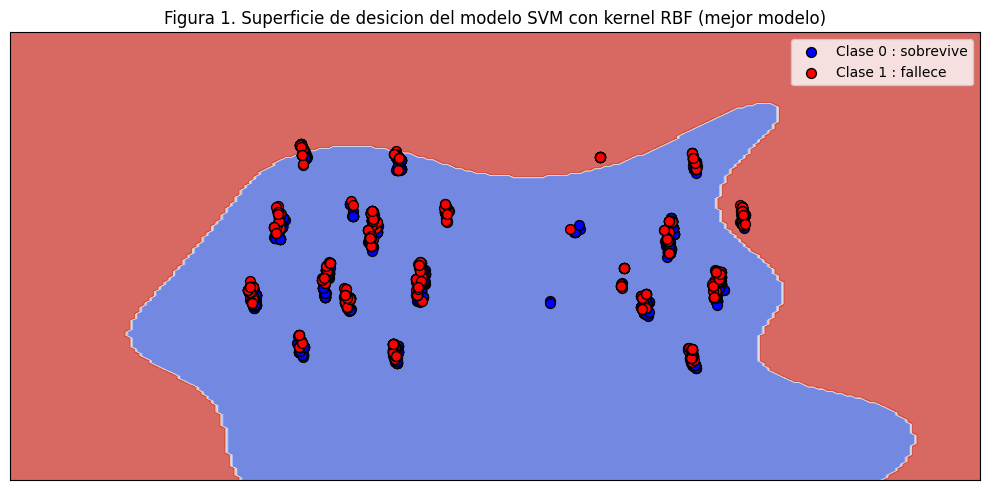

In [146]:
# Crear una figura
plt.figure(figsize=(10, 5))

# Graficar el SVM con kernel RBF

plot_decision_regions(X_train, y_train, modelo_svm_optimizado)
plt.title('Figura 1. Superficie de desicion del modelo SVM con kernel RBF (mejor modelo)')


# Mostrar la gráfica
plt.tight_layout()
plt.show()


En la Figura 1 se observa la superficie de decisión del modelo SVM optimizado. La clase 0 representa a los pacientes que no fallecieron y la clase 1 a los que sí. Se puede observar que las clases han sido separadas correctamente. Esto se debe a que se realizó una reducción de dimensionalidad con PCA, reduciendo de 13 variables a 2 con el objetivo de ilustrar cómo el modelo SVM clasifica o predice.